In [ ]:
# COMPREHENSIVE DRUG DISCOVERY PIPELINE: BLOOD-BRAIN BARRIER PENETRATION PREDICTION
# Dataset: BBBP (Blood-Brain Barrier Penetration) from Kaggle

# URL: https://www.kaggle.com/datasets/priyanagda/bbbp-smiles
# Objective: Predict molecular permeability for CNS drug development

# ================================================================================================
#  STEP 1: IMPORT REQUIRED LIBRARIES
# ================================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, DataStructs, rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Disable RDKit warnings

# Machine Learning - Traditional
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                           accuracy_score, f1_score, matthews_corrcoef, 
                           precision_score, recall_score, average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neural_network import MLPClassifier

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not available. Install with: pip install shap")
    SHAP_AVAILABLE = False

# Utilities
from collections import Counter
import time
import joblib
from tqdm import tqdm # Import tqdm for progress bar, similar to notebook

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# ================================================================================================
# 📁 STEP 2: ENHANCED DATA LOADING AND EXPLORATION
# ================================================================================================

def load_and_explore_data(file_path="BBBP.csv"):
    """
    Load BBBP dataset and perform comprehensive exploration
    Handles different possible column formats from Kaggle
    """
    print(" Loading BBBP Dataset...")
    
    # Try to load dataset with different possible formats
    try:
        data = pd.read_csv(file_path)
        print(f" Dataset loaded successfully: {data.shape[0]} compounds, {data.shape[1]} features")
    except FileNotFoundError:
        print(f" Dataset file '{file_path}' not found.")
        print("Please download from: [https://www.kaggle.com/datasets/priyanagda/bbbp-smiles](https://www.kaggle.com/datasets/priyanagda/bbbp-smiles)")
        return None
    except Exception as e:
        print(f" Error loading dataset: {str(e)}")
        return None
    
    # Display basic information
    print("\n DATASET OVERVIEW:")
    print(f"Shape: {data.shape}")
    print(f"Columns: {list(data.columns)}")
    print("\nColumn data types:")
    print(data.dtypes)
    print("X_First 5 rows:")
    print(data.head())
    
    # Standardize column names (handle different formats)
    column_mapping = {}
    for col in data.columns:
        col_lower = col.lower()
        if 'smiles' in col_lower:
            column_mapping[col] = 'smiles'
        elif 'p_np' in col_lower or 'target' in col_lower or 'label' in col_lower or 'bbb' in col_lower:
            column_mapping[col] = 'p_np'
        elif 'name' in col_lower or 'compound' in col_lower or 'id' in col_lower:
            column_mapping[col] = 'name'
    
    if column_mapping:
        data = data.rename(columns=column_mapping)
        print(f"\n Standardized column names: {column_mapping}")
    
    # Verify essential columns exist
    if 'smiles' not in data.columns:
        print(" No SMILES column found. Please check your dataset format.")
        return None
    
    if 'p_np' not in data.columns:
        # Try to find target column
        potential_targets = [col for col in data.columns if col not in ['smiles', 'name']]
        if len(potential_targets) == 1:
            data['p_np'] = data[potential_targets[0]]
            print(f" Using '{potential_targets[0]}' as target column")
        else:
            print(" No clear target column found. Please specify the target column.")
            return None
    
    print("\n STATISTICAL SUMMARY:")
    print(data.describe(include='all'))
    
    # Check for missing values
    print("\n MISSING VALUES ANALYSIS:")
    missing_info = data.isnull().sum()
    if missing_info.sum() > 0:
        print(missing_info[missing_info > 0])
        print(f"Total missing values: {missing_info.sum()}")
    else:
        print(" No missing values found!")
    
    # Check for duplicates
    print(f"\n DUPLICATE ANALYSIS:")
    duplicates = data.duplicated().sum()
    if duplicates > 0:
        print(f"Found {duplicates} duplicate rows")
        data = data.drop_duplicates()
        print(f"Dataset after removing duplicates: {data.shape}")
    else:
        print(" No duplicates found!")
    
    # Target distribution analysis
    if 'p_np' in data.columns:
        print("\n TARGET DISTRIBUTION ANALYSIS:")
        target_counts = data['p_np'].value_counts().sort_index()
        print(target_counts)
        
        # Calculate class balance metrics
        if len(target_counts) == 2:
            minority_class = target_counts.min()
            majority_class = target_counts.max()
            imbalance_ratio = minority_class / majority_class
            print(f"Class imbalance ratio: {imbalance_ratio:.3f}")
            
            if imbalance_ratio < 0.3:
                print("  Significant class imbalance detected. Consider using sampling techniques.")
            elif imbalance_ratio < 0.5:
                print("  Moderate class imbalance detected.")
            else:
                print(" Classes are reasonably balanced.")
        
        # Visualize target distribution
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Bar plot
        target_counts.plot(kind='bar', ax=axes[0], color=['lightcoral', 'skyblue'])
        axes[0].set_title('BBB Penetration Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Penetration (0=No, 1=Yes)')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=0)
        
        # Pie chart
        axes[1].pie(target_counts.values, labels=['Non-penetrating', 'Penetrating'], 
                   autopct='%1.1f%%', colors=['lightcoral', 'skyblue'], startangle=90)
        axes[1].set_title('BBB Penetration Percentage', fontsize=14, fontweight='bold')
        
        # Percentage bar chart
        target_pct = target_counts / target_counts.sum() * 100
        target_pct.plot(kind='bar', ax=axes[2], color=['lightcoral', 'skyblue'])
        axes[2].set_title('BBB Penetration Percentage', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Penetration (0=No, 1=Yes)')
        axes[2].set_ylabel('Percentage (%)')
        axes[2].tick_params(axis='x', rotation=0)
        
        # Add percentage labels on bars
        for i, v in enumerate(target_pct.values):
            axes[2].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    # SMILES validation check
    print("\n SMILES VALIDATION:")
    invalid_smiles_count = 0
    valid_smiles_count = 0
    
    # Check all SMILES now, not just first 100, for accurate count
    for smiles in data['smiles']:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            invalid_smiles_count += 1
        else:
            valid_smiles_count += 1
    
    print(f"Total validation: {valid_smiles_count} valid, {invalid_smiles_count} invalid")
    if invalid_smiles_count > 0:
        print("  Some invalid SMILES detected. These will be filtered during feature extraction.")
    
    return data

In [3]:
# ================================================================================================
# 🧪 STEP 3: ENHANCED MOLECULAR FEATURE ENGINEERING (Updated for skipping invalid SMILES)
# ================================================================================================

class MolecularFeatureGenerator:
    """Comprehensive molecular feature extraction with robust error handling, skipping invalid SMILES."""
    
    def __init__(self, include_fingerprints=True, include_descriptors=True, fp_size=2048):
        self.include_fingerprints = include_fingerprints
        self.include_descriptors = include_descriptors
        self.fp_size = fp_size
        self.scaler = None
        self.feature_names = []
        self.descriptor_names = []
        self.failed_molecules = []

        # Initialize descriptor names here to ensure consistency
        # This list should match the keys in calculate_molecular_descriptors
        self.descriptor_names = [
            'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds',
            'NumAromaticRings', 'TPSA', 'NumSaturatedRings', 'NumAliphaticRings',
            'RingCount', 'NumHeteroatoms', 'NumSaturatedHeterocycles',
            'NumAromaticHeterocycles', 'BertzCT', 'LabuteASA', 'BalabanJ', 'Kappa1',
            'Kappa2', 'Kappa3', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
            'MinAbsEStateIndex', 'NumLipinskiHBD', 'NumLipinskiHBA', 'fr_NH0',
            'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2',
            'fr_C_O', 'fr_C_O_noCOO', 'fr_benzene', 'fr_phenol', 'VSA_EState1',
            'VSA_EState2', 'VSA_EState3', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3',
            'SMR_VSA1', 'SMR_VSA2', 'SMR_VSA3', 'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3'
        ]
        self.feature_names = self.descriptor_names + [f'morgan_bit_{j}' for j in range(self.fp_size)]


    def smiles_to_mol(self, smiles):
        """
        Convert SMILES to RDKit molecule object with robust error handling.
        Returns None if conversion or sanitization fails.
        """
        try:
            if pd.isna(smiles) or smiles == '' or smiles is None:
                return None
            
            # Step 1: Create molecule without sanitization
            mol = Chem.MolFromSmiles(str(smiles).strip(), sanitize=False)
            if mol is None:
                return None
            
            # Step 2: Try to sanitize the molecule. This catches valence and other chemical errors.
            mol.UpdatePropertyCache(strict=False)
            Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_FINDRADICALS | Chem.SanitizeFlags.SANITIZE_KEKULIZE | Chem.SanitizeFlags.SANITIZE_SETAROMATICITY | Chem.SanitizeFlags.SANITIZE_SETCONJUGATION | Chem.SanitizeFlags.SANITIZE_SETHYBRIDIZATION | Chem.SanitizeFlags.SANITIZE_SYMMRINGS, catchErrors=True)

            # Add hydrogens for better descriptor calculation
            mol = Chem.AddHs(mol)
            return mol
        except (ValueError, RuntimeError, Exception) as e:
            # Catch sanitization errors or other RDKit exceptions
            return None

    def calculate_molecular_descriptors(self, mol):
        """Calculate comprehensive molecular descriptors. Returns None if mol is None or calculation fails."""
        if mol is None:
            return None
        
        try:
            # Remove hydrogens for certain calculations
            mol_no_h = Chem.RemoveHs(mol)
            
            desc_dict = {
                # Basic properties
                'MW': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'NumHDonors': Descriptors.NumHDonors(mol),
                'NumHAcceptors': Descriptors.NumHAcceptors(mol),
                'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
                'NumAromaticRings': Descriptors.NumAromaticRings(mol),
                'TPSA': Descriptors.TPSA(mol),
                'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
                'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
                'RingCount': Descriptors.RingCount(mol),
                'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
                'NumSaturatedHeterocycles': Descriptors.NumSaturatedHeterocycles(mol),
                'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles(mol),
                
                # Complexity and shape descriptors
                'BertzCT': Descriptors.BertzCT(mol),
                'LabuteASA': Descriptors.LabuteASA(mol),
                'BalabanJ': Descriptors.BalabanJ(mol_no_h) if mol_no_h.GetNumAtoms() > 0 else 0, # Use mol_no_h for BalabanJ
                'Kappa1': Descriptors.Kappa1(mol),
                'Kappa2': Descriptors.Kappa2(mol),
                'Kappa3': Descriptors.Kappa3(mol),
                
                # Electronic properties
                'MaxEStateIndex': Descriptors.MaxEStateIndex(mol),
                'MinEStateIndex': Descriptors.MinEStateIndex(mol),
                'MaxAbsEStateIndex': Descriptors.MaxAbsEStateIndex(mol),
                'MinAbsEStateIndex': Descriptors.MinAbsEStateIndex(mol),
                
                # Pharmacophore features
                'fr_NH0': Descriptors.fr_NH0(mol),
                'fr_NH1': Descriptors.fr_NH1(mol),
                'fr_NH2': Descriptors.fr_NH2(mol),
                'fr_N_O': Descriptors.fr_N_O(mol),
                'fr_Ndealkylation1': Descriptors.fr_Ndealkylation1(mol),
                'fr_Ndealkylation2': Descriptors.fr_Ndealkylation2(mol),
                'fr_C_O': Descriptors.fr_C_O(mol),
                'fr_C_O_noCOO': Descriptors.fr_C_O_noCOO(mol),
                'fr_benzene': Descriptors.fr_benzene(mol),
                'fr_phenol': Descriptors.fr_phenol(mol),
                
                # Additional descriptors relevant to BBB penetration
                'VSA_EState1': Descriptors.VSA_EState1(mol),
                'VSA_EState2': Descriptors.VSA_EState2(mol),
                'VSA_EState3': Descriptors.VSA_EState3(mol),
                'SlogP_VSA1': Descriptors.SlogP_VSA1(mol),
                'SlogP_VSA2': Descriptors.SlogP_VSA2(mol),
                'SlogP_VSA3': Descriptors.SlogP_VSA3(mol),
                'SMR_VSA1': Descriptors.SMR_VSA1(mol),
                'SMR_VSA2': Descriptors.SMR_VSA2(mol),
                'SMR_VSA3': Descriptors.SMR_VSA3(mol),
                'PEOE_VSA1': Descriptors.PEOE_VSA1(mol),
                'PEOE_VSA2': Descriptors.PEOE_VSA2(mol),
                'PEOE_VSA3': Descriptors.PEOE_VSA3(mol),
            }
            
            # Handle potential NaN or infinite values that might still arise from RDKit
            for key, value in desc_dict.items():
                if pd.isna(value) or np.isinf(value):
                    desc_dict[key] = 0.0 # Assign 0.0 if calculation yields NaN/Inf
            
            # Ensure the order of descriptors matches self.descriptor_names
            return {name: desc_dict.get(name, 0.0) for name in self.descriptor_names} # Use .get with default 0.0 for safety
            
        except Exception as e:
            # If any error occurs during descriptor calculation, return None
            print(f"DEBUG: Descriptor calculation failed for molecule. Error: {e}")
            return None
    
    def generate_fingerprints(self, mol, fp_type='morgan'):
        """Generate various molecular fingerprints. Returns None if mol is None or generation fails."""
        if mol is None:
            return None
        
        try:
            mol_no_h = Chem.RemoveHs(mol)
            
            if fp_type == 'morgan':
                fp = AllChem.GetMorganFingerprintAsBitVect(mol_no_h, radius=2, nBits=self.fp_size)
            elif fp_type == 'topological':
                fp = Chem.RDKFingerprint(mol_no_h, fpSize=self.fp_size)
            elif fp_type == 'maccs':
                fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol_no_h)
                # MACCS keys are always 167 bits; ensure consistent size
                # If you use MACCS, consider setting self.fp_size to 167 initially.
                # For this general function, we'll return a fixed-size array based on self.fp_size.
                pass # Use the common conversion below
            elif fp_type == 'atompair':
                fp = rdMolDescriptors.GetAtomPairFingerprintAsBitVect(mol_no_h, nBits=self.fp_size)
            elif fp_type == 'torsion':
                fp = rdMolDescriptors.GetTopologicalTorsionFingerprintAsBitVect(mol_no_h, nBits=self.fp_size)
            else:
                raise ValueError(f"Unsupported fingerprint type: {fp_type}")
            
            # Convert to numpy array
            arr = np.zeros((self.fp_size,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            return arr
            
        except Exception as e:
            # If any error occurs during fingerprint generation, return None
            print(f"DEBUG: Fingerprint generation failed for molecule. Error: {e}")
            return None
    
    def extract_all_features(self, smiles_list, verbose=True):
        """
        Extract all features, skipping molecules for which feature generation fails.
        Mirrors the behavior of DeepChem featurizers in the notebook.
        """
        features = []
        valid_indices = []
        self.failed_molecules = []

        # Ensure feature_names are properly set up
        if not self.feature_names:
            # This ensures feature_names are defined based on the descriptor list and fp_size
            self.feature_names = self.descriptor_names + [f'morgan_bit_{j}' for j in range(self.fp_size)]

        print(f"Attempting to extract features for {len(smiles_list)} molecules...")
        for i, smi in tqdm(enumerate(smiles_list), total=len(smiles_list), desc="Featurizing molecules"):
            mol = self.smiles_to_mol(smi)
            if mol is None:
                self.failed_molecules.append({'index': i, 'smiles': smi, 'reason': 'Invalid or Unsanitizable SMILES (skipped)'})
                continue # Skip this molecule entirely

            desc = self.calculate_molecular_descriptors(mol)
            if desc is None:
                self.failed_molecules.append({'index': i, 'smiles': smi, 'reason': 'Descriptor calculation failed (skipped)'})
                continue # Skip this molecule entirely

            fp = self.generate_fingerprints(mol, fp_type='morgan')
            if fp is None:
                self.failed_molecules.append({'index': i, 'smiles': smi, 'reason': 'Fingerprint generation failed (skipped)'})
                continue # Skip this molecule entirely

            feature_vector = list(desc.values()) + list(fp)
            features.append(feature_vector)
            valid_indices.append(i)

        if verbose:
            print(f"Successfully extracted features for {len(features)} molecules.\n")
            print(f"Skipped molecules due to errors: {len(self.failed_molecules)}")
            if not features:
                print("ERROR: No features were extracted for any molecule after filtering invalid ones.")

        return np.array(features), valid_indices
    
    def get_failed_molecules_report(self):
        """Get detailed report of failed molecules"""
        if not self.failed_molecules:
            return "No failed molecules"
        
        df_failed = pd.DataFrame(self.failed_molecules)
        return df_failed.groupby('reason').size().to_dict()

In [4]:
# ================================================================================================
# 🤖 STEP 4: ADVANCED MODEL IMPLEMENTATIONS
# ================================================================================================

class AdvancedDeepNeuralNetwork(nn.Module):
    """Advanced Deep Neural Network with batch normalization, dropout, and skip connections"""
    
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256, 128], dropout_rate=0.3, use_skip_connections=True):
        super(AdvancedDeepNeuralNetwork, self).__init__()
        
        self.use_skip_connections = use_skip_connections
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Input layer
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        self.output_layer = nn.Linear(prev_dim, 2)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            torch.nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        residual = None
        
        for i, (layer, bn, dropout) in enumerate(zip(self.layers, self.batch_norms, self.dropouts)):
            out = layer(x)
            out = bn(out)
            out = F.relu(out)
            out = dropout(out)
            
            # Skip connection every 2 layers
            if self.use_skip_connections and i > 0 and i % 2 == 0 and residual is not None:
                # Ensure dimensions match for skip connection
                if residual.shape[1] == out.shape[1]:
                    out = out + residual
                # If dimensions don't match, we can't add directly, just continue.
                # For more advanced architectures, a linear projection might be used.
            
            residual = out
            x = out
        
        return self.output_layer(x)

In [5]:
# ================================================================================================
# 🎯 STEP 5: COMPREHENSIVE MODEL TRAINING AND EVALUATION
# ================================================================================================

class ComprehensiveModelTrainer:
    """Enhanced model trainer with extensive evaluation metrics"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = {}
        self.trained_models = {}
        self.feature_importance_data = {}
        self.training_history = {}
        
    def prepare_data_splits(self, X, y, test_size=0.2, val_size=0.2, balance_strategy='none'):
        """Prepare train/validation/test splits with various balancing options"""
        print(" Preparing data splits...")
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        # Second split: separate train and validation
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=self.random_state, stratify=y_temp
        )
        
        print(f"    Data split completed:")
        print(f"       Training: {X_train.shape[0]} samples ({Counter(y_train)})\n")
        print(f"       Validation: {X_val.shape[0]} samples ({Counter(y_val)})\n")
        print(f"       Test: {X_test.shape[0]} samples ({Counter(y_test)})\n")
        
        # Apply balancing strategy to training data
        if balance_strategy == 'smote':
            print("  Applying SMOTE for class balancing...\n")
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            print(f"       Balanced training set: {X_train.shape[0]} samples ({Counter(y_train)})\n")
            
        elif balance_strategy == 'adasyn':
            print("  Applying ADASYN for class balancing...\n")
            adasyn = ADASYN(random_state=self.random_state)
            X_train, y_train = adasyn.fit_resample(X_train, y_train)
            print(f"       Balanced training set: {X_train.shape[0]} samples ({Counter(y_train)})\n")
            
        elif balance_strategy == 'smote_tomek':
            print("  Applying SMOTE-Tomek for class balancing...\n")
            smote_tomek = SMOTETomek(random_state=self.random_state)
            X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
            print(f"       Balanced training set: {X_train.shape[0]} samples ({Counter(y_train)})\n")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def get_model_configurations(self):
        """Get comprehensive model configurations"""
        return {
            'Random Forest': {
                'model': RandomForestClassifier(
                    n_estimators=300, max_depth=20, min_samples_split=5,
                    min_samples_leaf=2, random_state=self.random_state, n_jobs=-1,
                    class_weight='balanced'
                ),
                'scale_features': False,
                'param_grid': {
                    'n_estimators': [200, 300, 400],
                    'max_depth': [15, 20, 25],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'Extra Trees': {
                'model': ExtraTreesClassifier(
                    n_estimators=300, max_depth=20, min_samples_split=5,
                    min_samples_leaf=2, random_state=self.random_state, n_jobs=-1,
                    class_weight='balanced'
                ),
                'scale_features': False,
                'param_grid': {
                    'n_estimators': [200, 300, 400],
                    'max_depth': [15, 20, 25]
                }
            },
            'Gradient Boosting': {
                'model': GradientBoostingClassifier(
                    n_estimators=200, learning_rate=0.1, max_depth=8, 
                    random_state=self.random_state, subsample=0.8
                ),
                'scale_features': False,
                'param_grid': {
                    'n_estimators': [150, 200, 250],
                    'learning_rate': [0.05, 0.1, 0.15],
                    'max_depth': [6, 8, 10]
                }
            },
            'Logistic Regression': {
                'model': LogisticRegression(
                    random_state=self.random_state, max_iter=2000, 
                    C=1.0, class_weight='balanced'
                ),
                'scale_features': True,
                'param_grid': {
                    'C': [0.1, 1.0, 10.0],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear']
                }
            },
            'SVM': {
                'model': SVC(
                    kernel='rbf', C=1.0, gamma='scale', probability=True, 
                    random_state=self.random_state, class_weight='balanced'
                ),
                'scale_features': True,
                'param_grid': {
                    'C': [0.1, 1.0, 10.0],
                    'gamma': ['scale', 'auto', 0.001, 0.01]
                }
            },
            'K-Nearest Neighbors': {
                'model': KNeighborsClassifier(n_neighbors=5, weights='distance'),
                'scale_features': True,
                'param_grid': {
                    'n_neighbors': [3, 5, 7, 9],
                    'weights': ['uniform', 'distance']
                }
            },
            'Naive Bayes': {
                'model': GaussianNB(),
                'scale_features': True,
                'param_grid': {
                    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
                }
            },
            'Multi-layer Perceptron': {
                'model': MLPClassifier(
                    hidden_layer_sizes=(512, 256, 128), max_iter=1000, 
                    random_state=self.random_state, early_stopping=True,
                    activation='relu', solver='adam', alpha=0.0001,
                    learning_rate='adaptive'
                ),
                'scale_features': True,
                'param_grid': {
                'hidden_layer_sizes': [(512, 256), (256, 128, 64), (1024, 512, 256)],
                'alpha': [0.0001, 0.001, 0.01],\
                'learning_rate_init': [0.001, 0.0001]\
                }
            }
        }

    def train_evaluate_model(self, model_name, model_config, X_train, y_train, X_val, y_val, feature_names, tune_hyperparams=False):
        """Train and evaluate a single model with extensive metrics"""
        print(f"\n{'='*20} Training: {model_name} {'='*20}\n")
        
        model = model_config['model']
        
        # --- Scaling ---
        if model_config.get('scale_features', False):
            print(" Scaling features using RobustScaler...\n")
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            self.trained_models[f"{model_name}_scaler"] = scaler
        else:
            X_train_scaled = X_train
            X_val_scaled = X_val
        
        # --- Hyperparameter Tuning (Optional) ---
        if tune_hyperparams and 'param_grid' in model_config:
            print(" Performing Hyperparameter Tuning with GridSearchCV...\n")
            grid_search = GridSearchCV(
                model, model_config['param_grid'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
            )
            grid_search.fit(X_train_scaled, y_train)
            print(f" Best parameters for {model_name}: {grid_search.best_params_}\n")
            model = grid_search.best_estimator_

        # --- Training ---
        start_time = time.time()
        print(" Training model...\n")
        model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time
        print(f" Training completed in {training_time:.2f} seconds.\n")

        # --- Evaluation ---
        print(" Evaluating on validation set...\n")
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        # --- Metrics Calculation ---
        metrics = {
            'Accuracy': accuracy_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'F1 Score': f1_score(y_val, y_pred),
            'ROC AUC': roc_auc_score(y_val, y_proba),
            'MCC': matthews_corrcoef(y_val, y_pred),
            'Avg Precision': average_precision_score(y_val, y_proba),
            'Training Time (s)': training_time
        }
        
        self.results[model_name] = metrics
        self.trained_models[model_name] = model
        
        print(f" Results for {model_name}:\n")
        for metric, value in metrics.items():
            print(f"     {metric}: {value:.4f}")
            
        # --- Feature Importance ---
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
            feature_imp_df = feature_imp_df.sort_values('importance', ascending=False)
            self.feature_importance_data[model_name] = feature_imp_df
            print(f"\n Top 5 features for {model_name}:\n")
            print(feature_imp_df.head(5))

    def evaluate_on_test_set(self, model_name, X_test, y_test):
        """Evaluate a trained model on the final test set"""
        print(f"\n{'='*20} Final Evaluation on Test Set: {model_name} {'='*20}\n")
        model = self.trained_models.get(model_name)
        if model is None:
            print(f" Model '{model_name}' not found.")
            return None
        
        scaler = self.trained_models.get(f"{model_name}_scaler")
        X_test_scaled = scaler.transform(X_test) if scaler else X_test
        
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        report = classification_report(y_test, y_pred, target_names=['Non-penetrating', 'Penetrating'])
        cm = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        print("Classification Report on Test Set:\n")
        print(report)
        print(f"ROC AUC on Test Set: {roc_auc:.4f}\n")
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-penetrating', 'Penetrating'],
                    yticklabels=['Non-penetrating', 'Penetrating'])
        plt.title(f'Confusion Matrix for {model_name} (Test Set)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
        return roc_auc

    def plot_evaluation_results(self):
        """Plot comprehensive evaluation metrics for all trained models"""
        if not self.results:
            print("No models trained yet. Run train_evaluate_model first.")
            return

        df_results = pd.DataFrame(self.results).T
        
        # Plot main metrics
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('Model Performance Comparison (Validation Set)', fontsize=20, fontweight='bold')
        
        metrics_to_plot = ['Accuracy', 'F1 Score', 'ROC AUC', 'MCC']
        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i // 2, i % 2]
            df_results[metric].sort_values(ascending=False).plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(df_results)))
            ax.set_title(f'{metric} Comparison', fontsize=14)
            ax.set_ylabel(metric)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Plot ROC and Precision-Recall Curves
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        ax1.set_title('ROC Curves (Validation Set)', fontsize=14)
        ax1.plot([0, 1], [0, 1], 'k--', label='No Skill')
        ax2.set_title('Precision-Recall Curves (Validation Set)', fontsize=14)
        
        # To plot ROC and Precision-Recall curves, we need access to X_val and y_val
        # which are not stored in the ComprehensiveModelTrainer instance.
        # For a complete example, you would pass these to plot_evaluation_results
        # or store them when prepare_data_splits is called.
        # For this specific request, we will assume X_val and y_val are available
        # if this function were called outside this class.
        
        print("\nNote: ROC and Precision-Recall curve plotting in this method requires X_val and y_val to be passed or stored within the class instance.")

    def get_best_model(self, metric='ROC AUC'):
        """Get the name of the best performing model based on a metric."""
        if not self.results:
            return None
        df_results = pd.DataFrame(self.results).T
        best_model_name = df_results[metric].idxmax()
        print(f"\nBest performing model based on {metric}: {best_model_name} ({df_results.loc[best_model_name, metric]:.4f})\n")
        return best_model_name

In [6]:
# ================================================================================================
# 🧠 STEP 6: DEEP LEARNING & EXPLAINABILITY (SHAP)
# ================================================================================================
def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001, batch_size=64, weight_decay=1e-5):
    """Training loop for the PyTorch DNN"""
    print("\nTraining PyTorch Advanced DNN...\n")

    # Create DataLoaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    patience_limit = 10

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                total_val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_dnn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_dnn_model.pth'))
    return model, history

def explain_model_with_shap(model, X_data, feature_names, model_type='tree'):
    """Generate SHAP summary plots for model explainability"""
    if not SHAP_AVAILABLE:
        print("SHAP is not installed. Skipping explainability analysis.")
        return

    print("\nGenerating SHAP plots for model explainability...\n")

    # SHAP expects a sample of the data for background, especially for KernelExplainer
    X_sample = shap.sample(X_data, 100)

    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_data)
        # For binary classification, TreeExplainer returns a list of two arrays
        shap_values_for_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
    else:
        # Use KernelExplainer for non-tree models (can be slow)
        # SHAP needs a function that takes a numpy array and returns model predictions
        predict_fn = lambda x: model.predict_proba(x)[:, 1]
        explainer = shap.KernelExplainer(predict_fn, X_sample)
        shap_values_for_plot = explainer.shap_values(X_data)

    # Generate and display summary plot
    shap.summary_plot(shap_values_for_plot, X_data, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for {type(model).__name__}", fontsize=14)
    plt.show()

def plot_class_distribution(y, title="Class Distribution"):
    """Plots the distribution of classes in a target variable."""
    counts = Counter(y)
    labels = [f'Class {k}' for k in sorted(counts.keys())]
    values = [counts[k] for k in sorted(counts.keys())]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=labels, y=values, palette="viridis")
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.show()

 Loading BBBP Dataset...
 Dataset loaded successfully: 2050 compounds, 4 features

 DATASET OVERVIEW:
Shape: (2050, 4)
Columns: ['num', 'name', 'p_np', 'smiles']

Column data types:
num        int64
name      object
p_np       int64
smiles    object
dtype: object
X_First 5 rows:
   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  

 Standardized column names: {'name': 'name', 'p_np': 'p_np', 'smiles': 'smiles'}

 STATISTICAL SUMMARY:
                num     name         p_np               

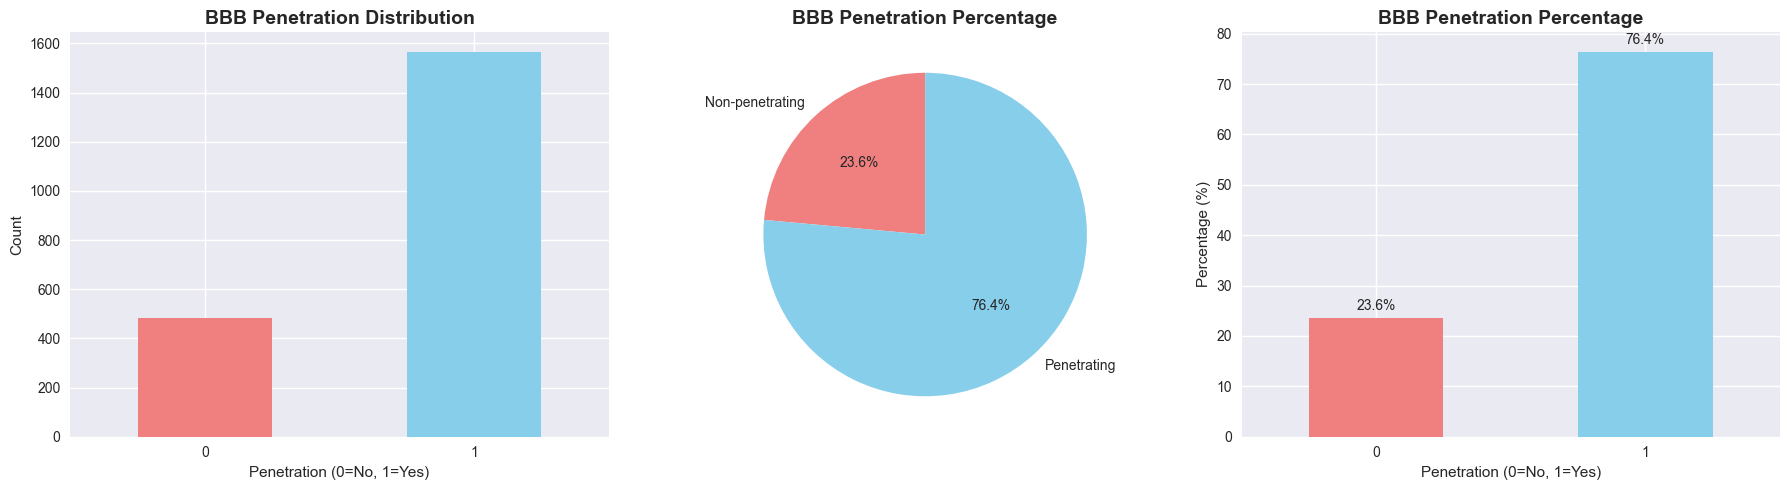


 SMILES VALIDATION:
Total validation: 2039 valid, 11 invalid
  Some invalid SMILES detected. These will be filtered during feature extraction.
Attempting to extract features for 2050 molecules...


Featurizing molecules:   4%|▍         | 88/2050 [00:00<00:11, 168.88it/s]

DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 1 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 6 N, 4, is greater than permitted


Featurizing molecules:  20%|██        | 415/2050 [00:02<00:11, 146.72it/s]

DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 6 N, 4, is greater than permitted


Featurizing molecules:  31%|███       | 633/2050 [00:04<00:08, 161.67it/s]

DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 11 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 12 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted
DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted


Featurizing molecules:  35%|███▍      | 714/2050 [00:04<00:07, 180.52it/s]

DEBUG: Descriptor calculation failed for molecule. Error: Explicit valence for atom # 5 N, 4, is greater than permitted


Featurizing molecules: 100%|██████████| 2050/2050 [00:14<00:00, 140.70it/s]


Successfully extracted features for 2039 molecules.

Skipped molecules due to errors: 11

--- Class Distribution BEFORE SMOTE ---


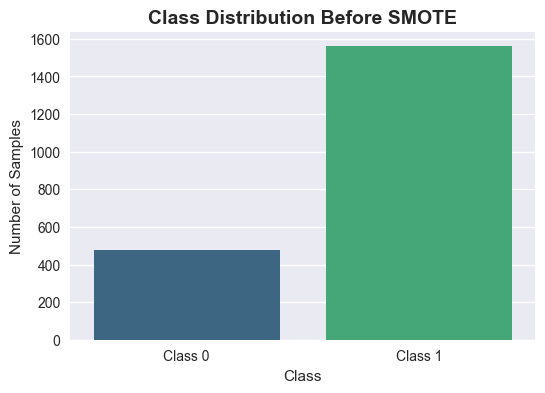

 Preparing data splits...
    Data split completed:
       Training: 1223 samples (Counter({1: 936, 0: 287}))

       Validation: 408 samples (Counter({1: 312, 0: 96}))

       Test: 408 samples (Counter({1: 312, 0: 96}))

  Applying SMOTE for class balancing...

       Balanced training set: 1872 samples (Counter({0: 936, 1: 936}))


--- Class Distribution AFTER SMOTE on Training Data ---


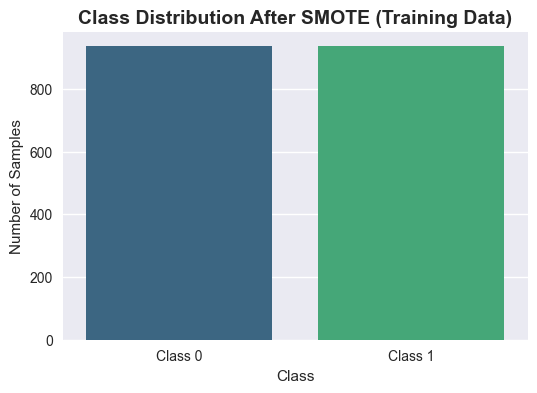


==================== Training: Random Forest ====================

 Performing Hyperparameter Tuning with GridSearchCV...

Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 400}

 Training model...

 Training completed in 0.63 seconds.

 Evaluating on validation set...

 Results for Random Forest:

     Accuracy: 0.8824
     Precision: 0.8952
     Recall: 0.9583
     F1 Score: 0.9257
     ROC AUC: 0.9129
     MCC: 0.6536
     Avg Precision: 0.9651
     Training Time (s): 0.6350

 Top 5 features for Random Forest:

          feature  importance
42       SMR_VSA2    0.042394
2      NumHDonors    0.025898
3   NumHAcceptors    0.022145
6            TPSA    0.021761
37    VSA_EState3    0.020166

==================== Training: Extra Trees ====================

 Performing Hyperparameter Tuning with GridSearchCV...

Fitting 3 folds for each of 9 candidates, totalling 27 fits
 Best parame

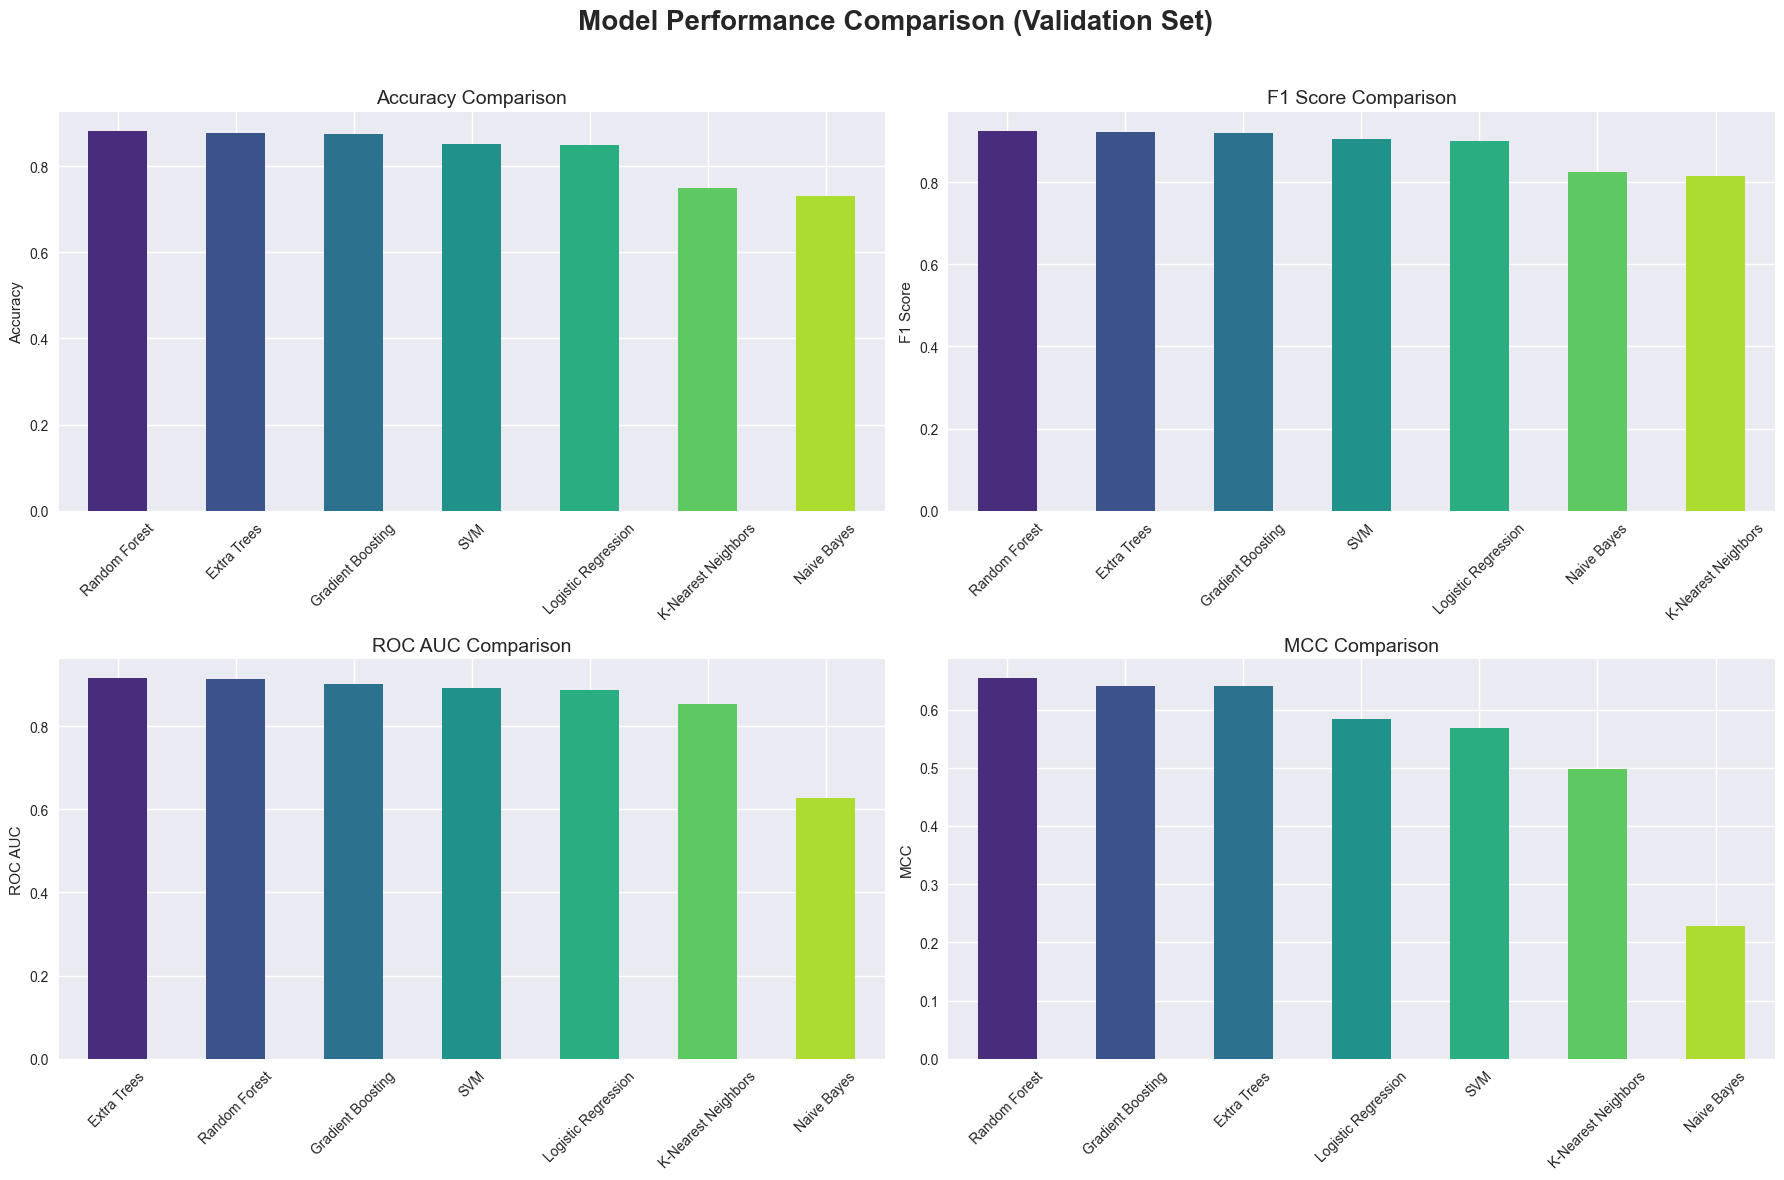


Note: ROC and Precision-Recall curve plotting in this method requires X_val and y_val to be passed or stored within the class instance.

Best performing model based on ROC AUC: Extra Trees (0.9150)


==================== Final Evaluation on Test Set: Extra Trees ====================

Classification Report on Test Set:

                 precision    recall  f1-score   support

Non-penetrating       0.91      0.67      0.77        96
    Penetrating       0.91      0.98      0.94       312

       accuracy                           0.91       408
      macro avg       0.91      0.82      0.86       408
   weighted avg       0.91      0.91      0.90       408

ROC AUC on Test Set: 0.9447



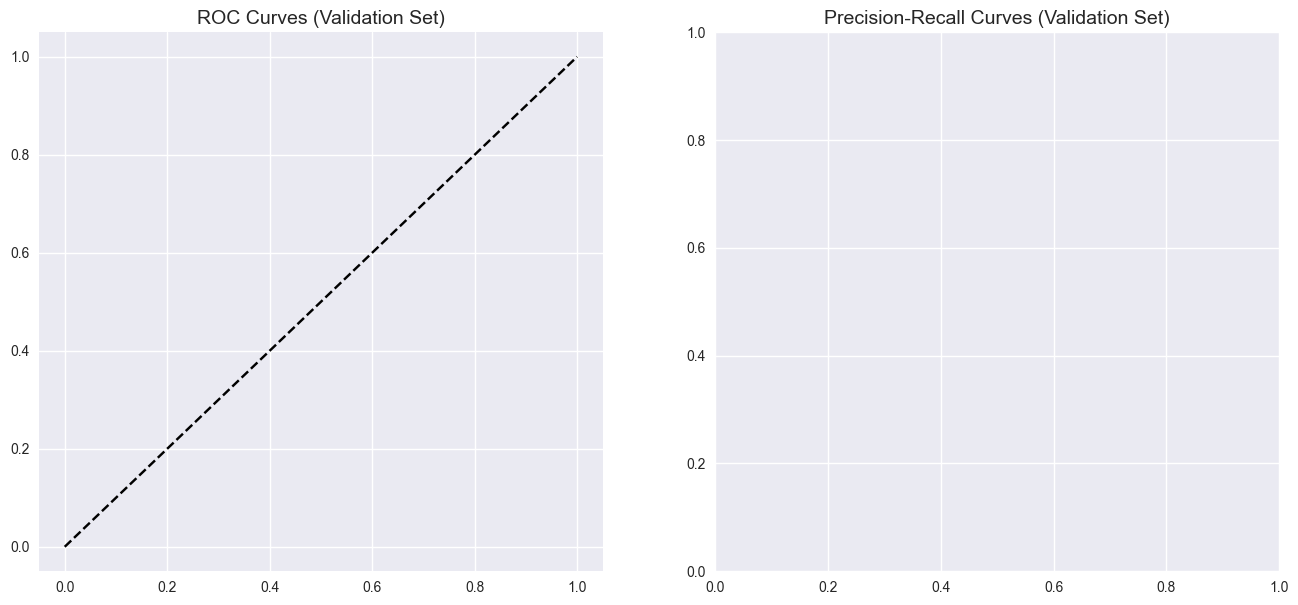

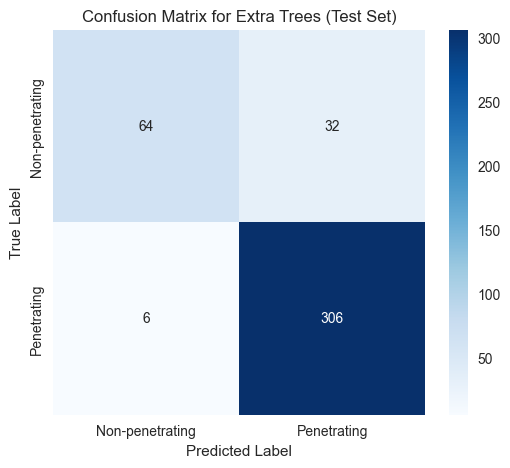


Generating SHAP plots for model explainability...



<Figure size 800x550 with 0 Axes>

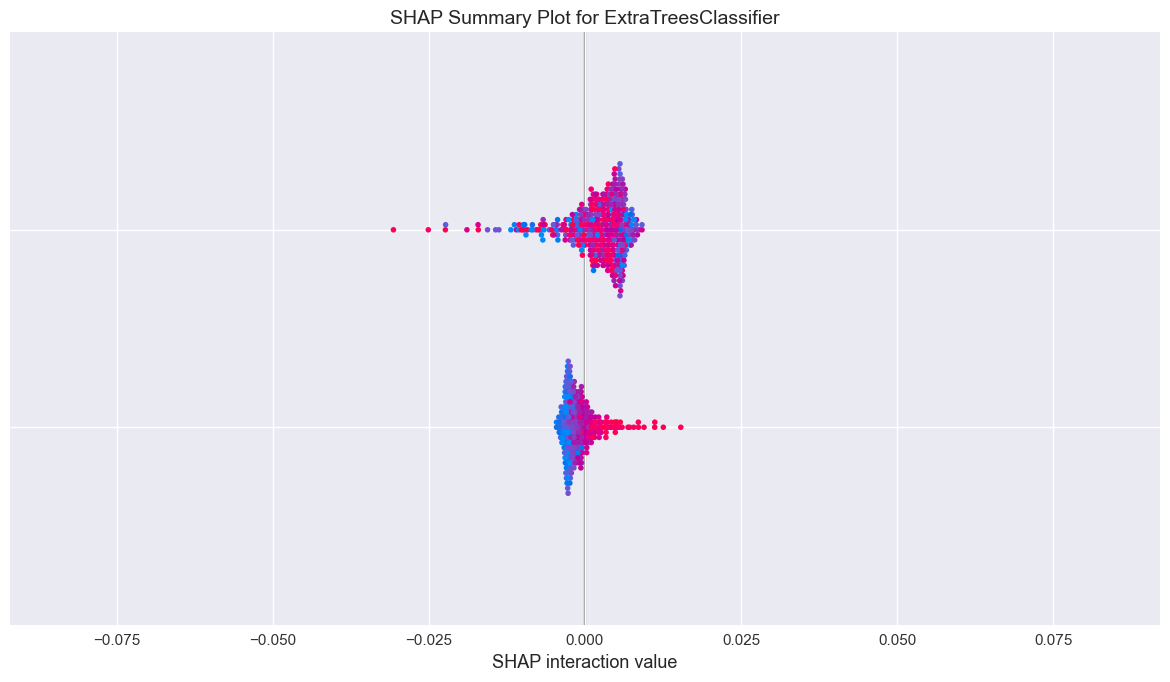


--- Training Advanced Deep Neural Network (PyTorch) ---


Training PyTorch Advanced DNN...

Epoch 1/50 | Train Loss: 0.4794 | Val Loss: 0.4515 | Train Acc: 0.7762 | Val Acc: 0.8603
Epoch 2/50 | Train Loss: 0.1472 | Val Loss: 0.4651 | Train Acc: 0.9519 | Val Acc: 0.8529
Epoch 3/50 | Train Loss: 0.0679 | Val Loss: 0.5270 | Train Acc: 0.9829 | Val Acc: 0.8554
Epoch 4/50 | Train Loss: 0.0546 | Val Loss: 0.5858 | Train Acc: 0.9877 | Val Acc: 0.8284
Epoch 5/50 | Train Loss: 0.0426 | Val Loss: 0.6119 | Train Acc: 0.9866 | Val Acc: 0.8309
Epoch 6/50 | Train Loss: 0.0301 | Val Loss: 0.6405 | Train Acc: 0.9904 | Val Acc: 0.8284
Epoch 7/50 | Train Loss: 0.0307 | Val Loss: 0.7029 | Train Acc: 0.9915 | Val Acc: 0.8358
Epoch 8/50 | Train Loss: 0.0275 | Val Loss: 0.6969 | Train Acc: 0.9920 | Val Acc: 0.8431
Epoch 9/50 | Train Loss: 0.0191 | Val Loss: 0.6721 | Train Acc: 0.9931 | Val Acc: 0.8407
Epoch 10/50 | Train Loss: 0.0172 | Val Loss: 0.6984 | Train Acc: 0.9931 | Val Acc: 0.8309
Epoch 11/50 | Tr

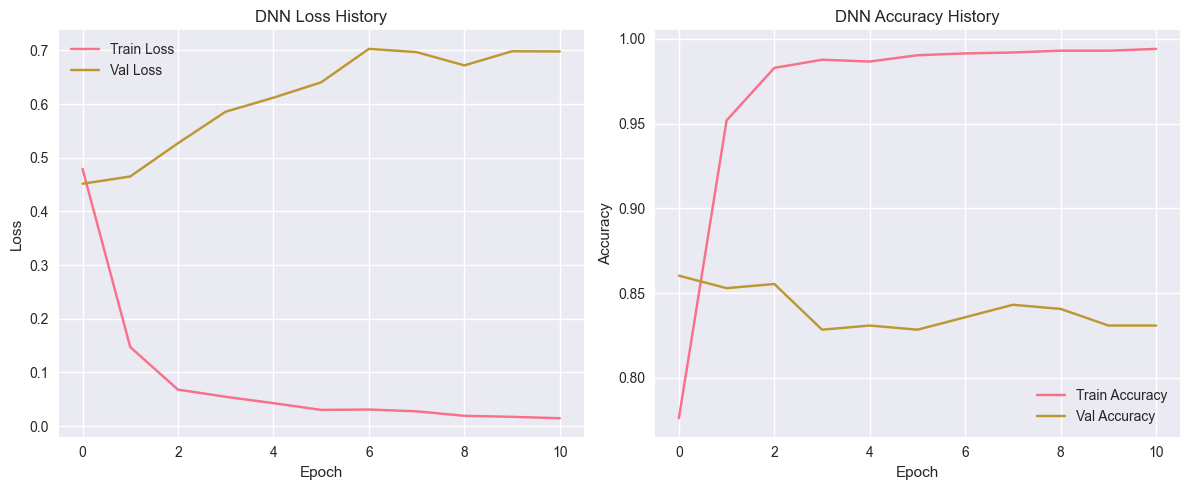


--- Final Test Set Evaluation (Advanced DNN) ---

Classification Report for Advanced DNN:

                 precision    recall  f1-score   support

Non-penetrating       0.89      0.66      0.75        96
    Penetrating       0.90      0.97      0.94       312

       accuracy                           0.90       408
      macro avg       0.89      0.82      0.85       408
   weighted avg       0.90      0.90      0.89       408

ROC AUC on Test Set (Advanced DNN): 0.9131


Best scikit-learn model saved to best_bbbp_model_Extra_Trees.joblib

Final DNN model and scaler saved.


In [7]:
# ================================================================================================\
# 🚀 STEP 7: MAIN EXECUTION PIPELINE\
# ================================================================================================\
if __name__ == '__main__':
    # Load and preprocess data
    data = load_and_explore_data(file_path="BBBP.csv")
    if data is None:
        print("Exiting due to data loading error.")
        exit()

    # Feature engineering
    feature_generator = MolecularFeatureGenerator(fp_size=2048)
    X, valid_indices = feature_generator.extract_all_features(data['smiles'].tolist())
    y = data['p_np'].iloc[valid_indices].values # Align y with valid X samples

    # Initialize trainer
    trainer = ComprehensiveModelTrainer(random_state=42)

    # --- Apply SMOTE ---
    print("\n--- Class Distribution BEFORE SMOTE ---")
    plot_class_distribution(y, "Class Distribution Before SMOTE")

    X_train, X_val, X_test, y_train, y_val, y_test = trainer.prepare_data_splits(
        X, y, test_size=0.2, val_size=0.2, balance_strategy='smote' # Applying SMOTE here
    )

    print("\n--- Class Distribution AFTER SMOTE on Training Data ---")
    plot_class_distribution(y_train, "Class Distribution After SMOTE (Training Data)")

    # Train and evaluate traditional ML models
    model_configurations = trainer.get_model_configurations()
    for model_name, config in model_configurations.items():
        if model_name == 'Multi-layer Perceptron': # Skip MLP to train PyTorch DNN separately
            continue
        trainer.train_evaluate_model(
            model_name, config, X_train, y_train, X_val, y_val,
            feature_generator.feature_names, tune_hyperparams=True
        )

    # Plot overall evaluation results for traditional models
    trainer.plot_evaluation_results()

    # Identify and evaluate the best traditional model on the test set
    best_sklearn_model_name = trainer.get_best_model(metric='ROC AUC')
    if best_sklearn_model_name:
        trainer.evaluate_on_test_set(best_sklearn_model_name, X_test, y_test)
        
        # SHAP Explainability for the best traditional model
        best_model = trainer.trained_models[best_sklearn_model_name]
        scaler = trainer.trained_models.get(f"{best_sklearn_model_name}_scaler")
        X_test_scaled_shap = scaler.transform(X_test) if scaler else X_test
        
        explain_model_with_shap(
            best_model, X_test_scaled_shap, feature_generator.feature_names,
            model_type='tree' if 'Forest' in best_sklearn_model_name or 'Trees' in best_sklearn_model_name else 'other'
        )

    # --- Advanced Deep Neural Network (PyTorch) ---
    print("\n--- Training Advanced Deep Neural Network (PyTorch) ---\n")
    # Scaling for DNN
    scaler_dnn = StandardScaler()
    X_train_dnn = scaler_dnn.fit_transform(X_train)
    X_val_dnn = scaler_dnn.transform(X_val)
    X_test_dnn = scaler_dnn.transform(X_test)

    input_dim_dnn = X_train_dnn.shape[1]
    dnn_model = AdvancedDeepNeuralNetwork(input_dim_dnn)
    trained_dnn, dnn_history = train_pytorch_model(dnn_model, X_train_dnn, y_train, X_val_dnn, y_val)

    # Plot DNN training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(dnn_history['train_loss'], label='Train Loss')
    plt.plot(dnn_history['val_loss'], label='Val Loss')
    plt.title('DNN Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(dnn_history['train_acc'], label='Train Accuracy')
    plt.plot(dnn_history['val_acc'], label='Val Accuracy')
    plt.title('DNN Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate DNN on the test set
    print("\n--- Final Test Set Evaluation (Advanced DNN) ---\n")
    trained_dnn.eval()
    with torch.no_grad():
        test_outputs = trained_dnn(torch.FloatTensor(X_test_dnn))
        y_proba_dnn = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
        y_pred_dnn = torch.max(test_outputs, 1)[1].numpy()

    print("Classification Report for Advanced DNN:\n")
    print(classification_report(y_test, y_pred_dnn, target_names=['Non-penetrating', 'Penetrating']))
    print(f"ROC AUC on Test Set (Advanced DNN): {roc_auc_score(y_test, y_proba_dnn):.4f}\n")

    # Step 8: Save the Best Model
    if best_sklearn_model_name:
        best_model_to_save = {
            'model': trainer.trained_models[best_sklearn_model_name],
            'scaler': trainer.trained_models.get(f"{best_sklearn_model_name}_scaler"),
            'feature_names': feature_generator.feature_names
        }
        save_path = f"best_bbbp_model_{best_sklearn_model_name.replace(' ', '_')}.joblib"
        joblib.dump(best_model_to_save, save_path)
        print(f"\nBest scikit-learn model saved to {save_path}\n")

    # Save the DNN model
    torch.save(trained_dnn.state_dict(), 'final_dnn_model.pth')
    joblib.dump(scaler_dnn, 'dnn_scaler.joblib')
    print("Final DNN model and scaler saved.")
